Analyzed total index: 0, URL index: 1 for URL: https://www.haberturk.com/images/common/manifest/180x180.png
Analyzed total index: 1, URL index: 1 for URL: https://www.haberturk.com/images/common/favicon/32x32.png
Analyzed total index: 2, URL index: 1 for URL: https://www.haberturk.com/images/common/favicon/16x16.png
Analyzed total index: 3, URL index: 1 for URL: https://www.haberturk.com/images/common/favicon/favicon.ico?v=001
Analyzed total index: 4, URL index: 1 for URL: https://www.haberturk.com/manifest.webmanifest
Analyzed total index: 5, URL index: 1 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL index: 2 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL index: 3 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL index: 4 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL index: 5 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL index: 6 for URL: https://adsp.haberturk.com
Analyzed total index: 5, URL in
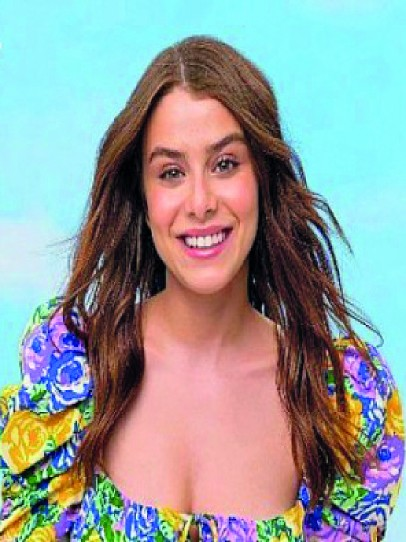
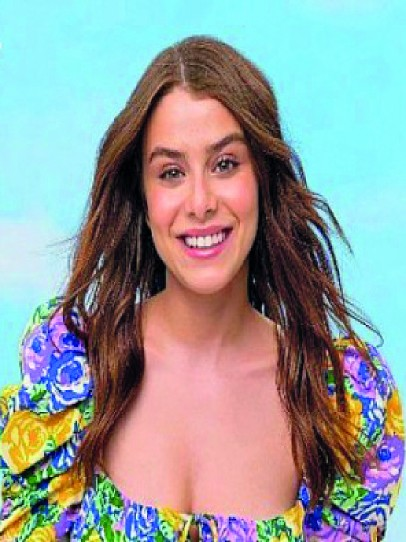

In [3]:
import json
import requests
from PIL import Image
from io import BytesIO
import xml.etree.ElementTree as ET

# load the image data from the JSON file
def load_image_data_from_json(filename='image_data.json'):
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# get the dimensions of an image from its URL
def get_image_dimensions(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # for bad responses

        # check if content type header is present and process SVG content
        content_type = response.headers.get('Content-Type', '')
        if 'svg' in content_type:
            # parse SVG to get width and height
            tree = ET.fromstring(response.content)
            width = tree.attrib.get('width')
            height = tree.attrib.get('height')
            dimensions = (width, height)
            return dimensions
        elif 'image' in content_type:
            # handle raster images
            image = Image.open(BytesIO(response.content))
            return (image.width, image.height)
        else:
            return 'Unsupported content type'

    except requests.RequestException as e:
        print(f"Request error for {image_url}: {e}")
        return None
    except IOError as e:
        print(f"Image loading error for {image_url}: {e}")
        return None
    except ET.ParseError as e:
        print(f"SVG parsing error for {image_url}: {e}")
        return 'Error parsing SVG'

# save the image data with dimensions and alt text to HTML
def save_images_with_dimensions_and_alt_to_html(image_data, filename='images_with_dimensions_and_alt.html'):
    html_content = '<html><head><title>Image Details</title></head><body><h1>Image Details</h1>'
    for page_url, images in image_data.items():
        html_content += f'<h2>URL: {page_url}</h2><ul>'
        for index, item in enumerate(images, start=1):
            url = item['url']
            alt_text = item['alt']
            dimensions = item.get('dimensions')
            if dimensions:
                if isinstance(dimensions, tuple):
                    width, height = dimensions
                    html_content += f'<li>{index}. <a href="{url}" target="_blank">{url}</a> - {width}x{height} - Alt Text: {alt_text}</li>'
                else:
                    html_content += f'<li>{index}. <a href="{url}" target="_blank">{url}</a> - {dimensions} - Alt Text: {alt_text}</li>'
            else:
                html_content += f'<li>{index}. <a href="{url}" target="_blank">{url}</a> - Error loading image - Alt Text: {alt_text}</li>'
        html_content += '</ul>'
    html_content += '</body></html>'
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(html_content)

# save the image data to a JSON file
def save_image_data_to_json(image_data, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(image_data, file, indent=4)

# main function to load image data, get dimensions and save results in batches
def main():
    all_image_data = load_image_data_from_json()
    total_urls = len(all_image_data)
    batch_size = 180

    for i in range(0, total_urls, batch_size):
        batch_data = dict(list(all_image_data.items())[i:i + batch_size])
        for index, (page_url, images) in enumerate(batch_data.items(), start=i):
            for img_index, item in enumerate(images, start=1):
                dimensions = get_image_dimensions(item['url'])
                item['dimensions'] = dimensions
                print(f"Analyzed total index: {index}, URL index: {img_index} for URL: {page_url}")

        json_filename = f'images_with_dimensions_and_alt_{i//batch_size + 1}.json'
        html_filename = f'images_with_dimensions_and_alt_batch_{i//batch_size + 1}.html'
        
        save_image_data_to_json(batch_data, json_filename)
        save_images_with_dimensions_and_alt_to_html(batch_data, html_filename)
        print(f"Saved batch {i//batch_size + 1} data to {json_filename} and {html_filename}")

if __name__ == "__main__":
    main()
